In [7]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [8]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [9]:
#Create Instances Of Utils Helper
seed = 5000
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",seed, create_dirs=True) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);



In [10]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

In [11]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y)

# Normalize data
X_train = X_train/255.
X_test = X_test/255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y_train)
old_y_train = Y_train

In [6]:
X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train, 30000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.3,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.1), seed=9634)

Data Augmentation with data distribution
Data distribution = [0.1270625 0.1242825 0.1244125 0.1244525 0.1242925 0.1267625 0.1242525
 0.1244825]
Class Size :  149, generating: 12706
11835 images generated
Class Size :  427, generating: 12428
11849 images generated
Class Size :  414, generating: 12441
12358 images generated
Class Size :  410, generating: 12445
12242 images generated
Class Size :  426, generating: 12429
11822 images generated
Class Size :  179, generating: 12676
11814 images generated
Class Size :  430, generating: 12425
11930 images generated
Class Size :  407, generating: 12448
12187 images generated


In [7]:
X_train.shape,X_test.shape,X_val.shape

((98879, 96, 96, 3), (354, 96, 96, 3), (354, 96, 96, 3))

In [8]:
Y_train.shape,Y_test.shape,Y_val.shape

((98879, 8), (354, 8), (354, 8))

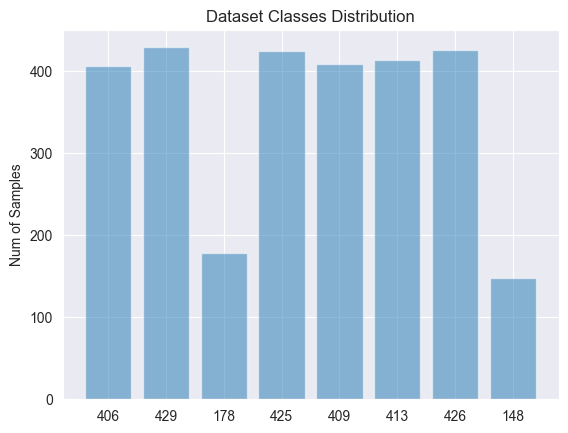

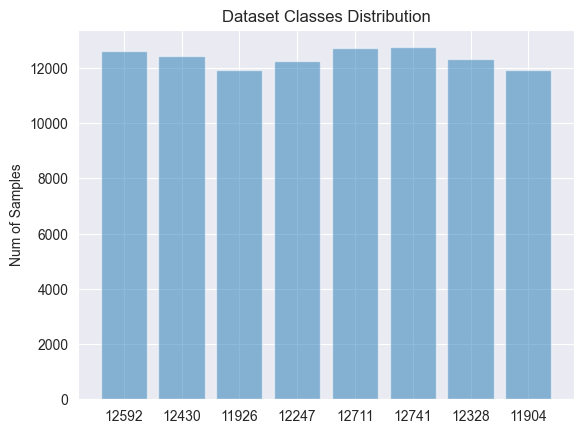

In [9]:
dataset_helper.plot_samples_distribution(old_y_train)
dataset_helper.plot_samples_distribution(Y_train)

In [10]:
input_shape = X_train.shape[1:] # 96*96*3
batch_size = 128
epochs = 50

In [11]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 10
    start_n_f = 64
    last_layer = input_layer
    for i in range(depth):
        kernel_size = (3,3) if i == 0 else (3,3)
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=kernel_size,
            strides = (1, 1),
            padding = 'same',
            activation = None,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        activation = tfkl.Activation('relu')(batch)
        last_layer = activation
        if i%2 == 0:
            pool = tfkl.MaxPooling2D((2,2), padding='same')(activation)
            last_layer = pool
            start_n_f *= (1 if i%2 == 0 else 2)

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=2048,
        name='Classifier',
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [12]:
model = build_model(input_shape)

2022-11-17 00:53:15.893485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 00:53:15.893956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928 

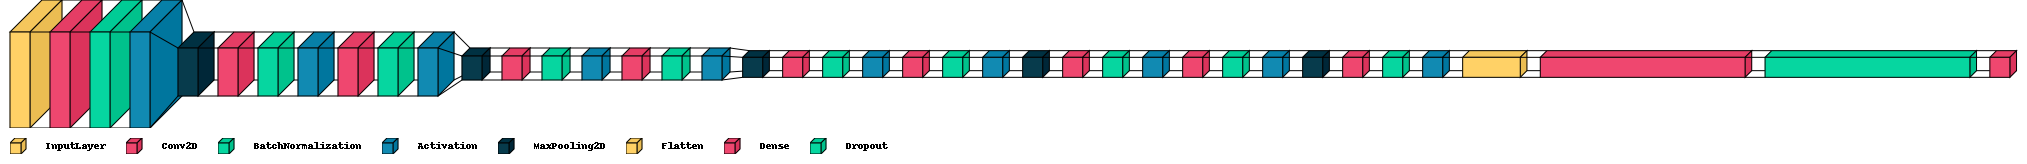

In [13]:
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

In [14]:
X_val.shape,Y_val.shape

((354, 96, 96, 3), (354, 8))

In [19]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=25)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = 100,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/100


2022-11-17 08:03:32.614669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


773/773 [==============================] - ETA: 0s - loss: 1.6524 - accuracy: 0.3082

2022-11-17 08:05:49.977913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


773/773 [==============================] - 141s 178ms/step - loss: 1.6524 - accuracy: 0.3082 - val_loss: 1.4023 - val_accuracy: 0.7571
Epoch 2/100
773/773 [==============================] - 137s 177ms/step - loss: 1.6523 - accuracy: 0.3080 - val_loss: 1.6373 - val_accuracy: 0.7429
Epoch 3/100
773/773 [==============================] - 137s 177ms/step - loss: 1.6495 - accuracy: 0.3088 - val_loss: 1.5235 - val_accuracy: 0.7373
Epoch 4/100
773/773 [==============================] - 137s 177ms/step - loss: 1.6508 - accuracy: 0.3086 - val_loss: 1.3620 - val_accuracy: 0.7429
Epoch 5/100
773/773 [==============================] - 136s 176ms/step - loss: 1.6514 - accuracy: 0.3103 - val_loss: 1.7743 - val_accuracy: 0.7260
Epoch 6/100
773/773 [==============================] - 136s 176ms/step - loss: 1.6506 - accuracy: 0.3093 - val_loss: 1.9634 - val_accuracy: 0.6667
Epoch 7/100
773/773 [==============================] - 135s 174ms/step - loss: 1.6512 - accuracy: 0.3088 - val_loss: 1.5058 - val_

In [24]:
model_helper.save_model(model,'model2')

INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


In [21]:

model = model_helper.load_model('model2')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928 

In [29]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y)

# Normalize data
X_train = X_train/255.
X_test = X_test/255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y_train)
old_y_train = Y_train

X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train, 40000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.3,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.2), seed=567)

Data Augmentation with data distribution
Data distribution = [0.13015625 0.12320625 0.12353125 0.12363125 0.12323125 0.12940625
 0.12313125 0.12370625]
Class Size :  149, generating: 5206
4832 images generated
Class Size :  427, generating: 4928
4697 images generated
Class Size :  414, generating: 4941
4906 images generated
Class Size :  410, generating: 4945
4862 images generated
Class Size :  426, generating: 4929
4686 images generated
Class Size :  179, generating: 5176
4814 images generated
Class Size :  430, generating: 4925
4716 images generated
Class Size :  407, generating: 4948
4829 images generated


In [30]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

Epoch 1/100
322/322 [==============================] - 45s 140ms/step - loss: 2.0074 - accuracy: 0.1624 - val_loss: 0.8192 - val_accuracy: 0.7486
Epoch 2/100
322/322 [==============================] - 44s 138ms/step - loss: 1.9975 - accuracy: 0.1674 - val_loss: 1.3153 - val_accuracy: 0.6610
Epoch 3/100
322/322 [==============================] - 45s 139ms/step - loss: 1.9906 - accuracy: 0.1684 - val_loss: 1.0783 - val_accuracy: 0.7203
Epoch 4/100
322/322 [==============================] - 44s 138ms/step - loss: 1.9841 - accuracy: 0.1693 - val_loss: 0.9235 - val_accuracy: 0.7401
Epoch 5/100
322/322 [==============================] - 44s 138ms/step - loss: 1.9836 - accuracy: 0.1692 - val_loss: 0.9307 - val_accuracy: 0.7684
Epoch 6/100
322/322 [==============================] - 44s 136ms/step - loss: 1.9788 - accuracy: 0.1713 - val_loss: 0.9334 - val_accuracy: 0.7514
Epoch 7/100
322/322 [==============================] - 44s 136ms/step - loss: 1.9762 - accuracy: 0.1704 - val_loss: 1.4909 -

12/12 [==============================] - 0s 17ms/step


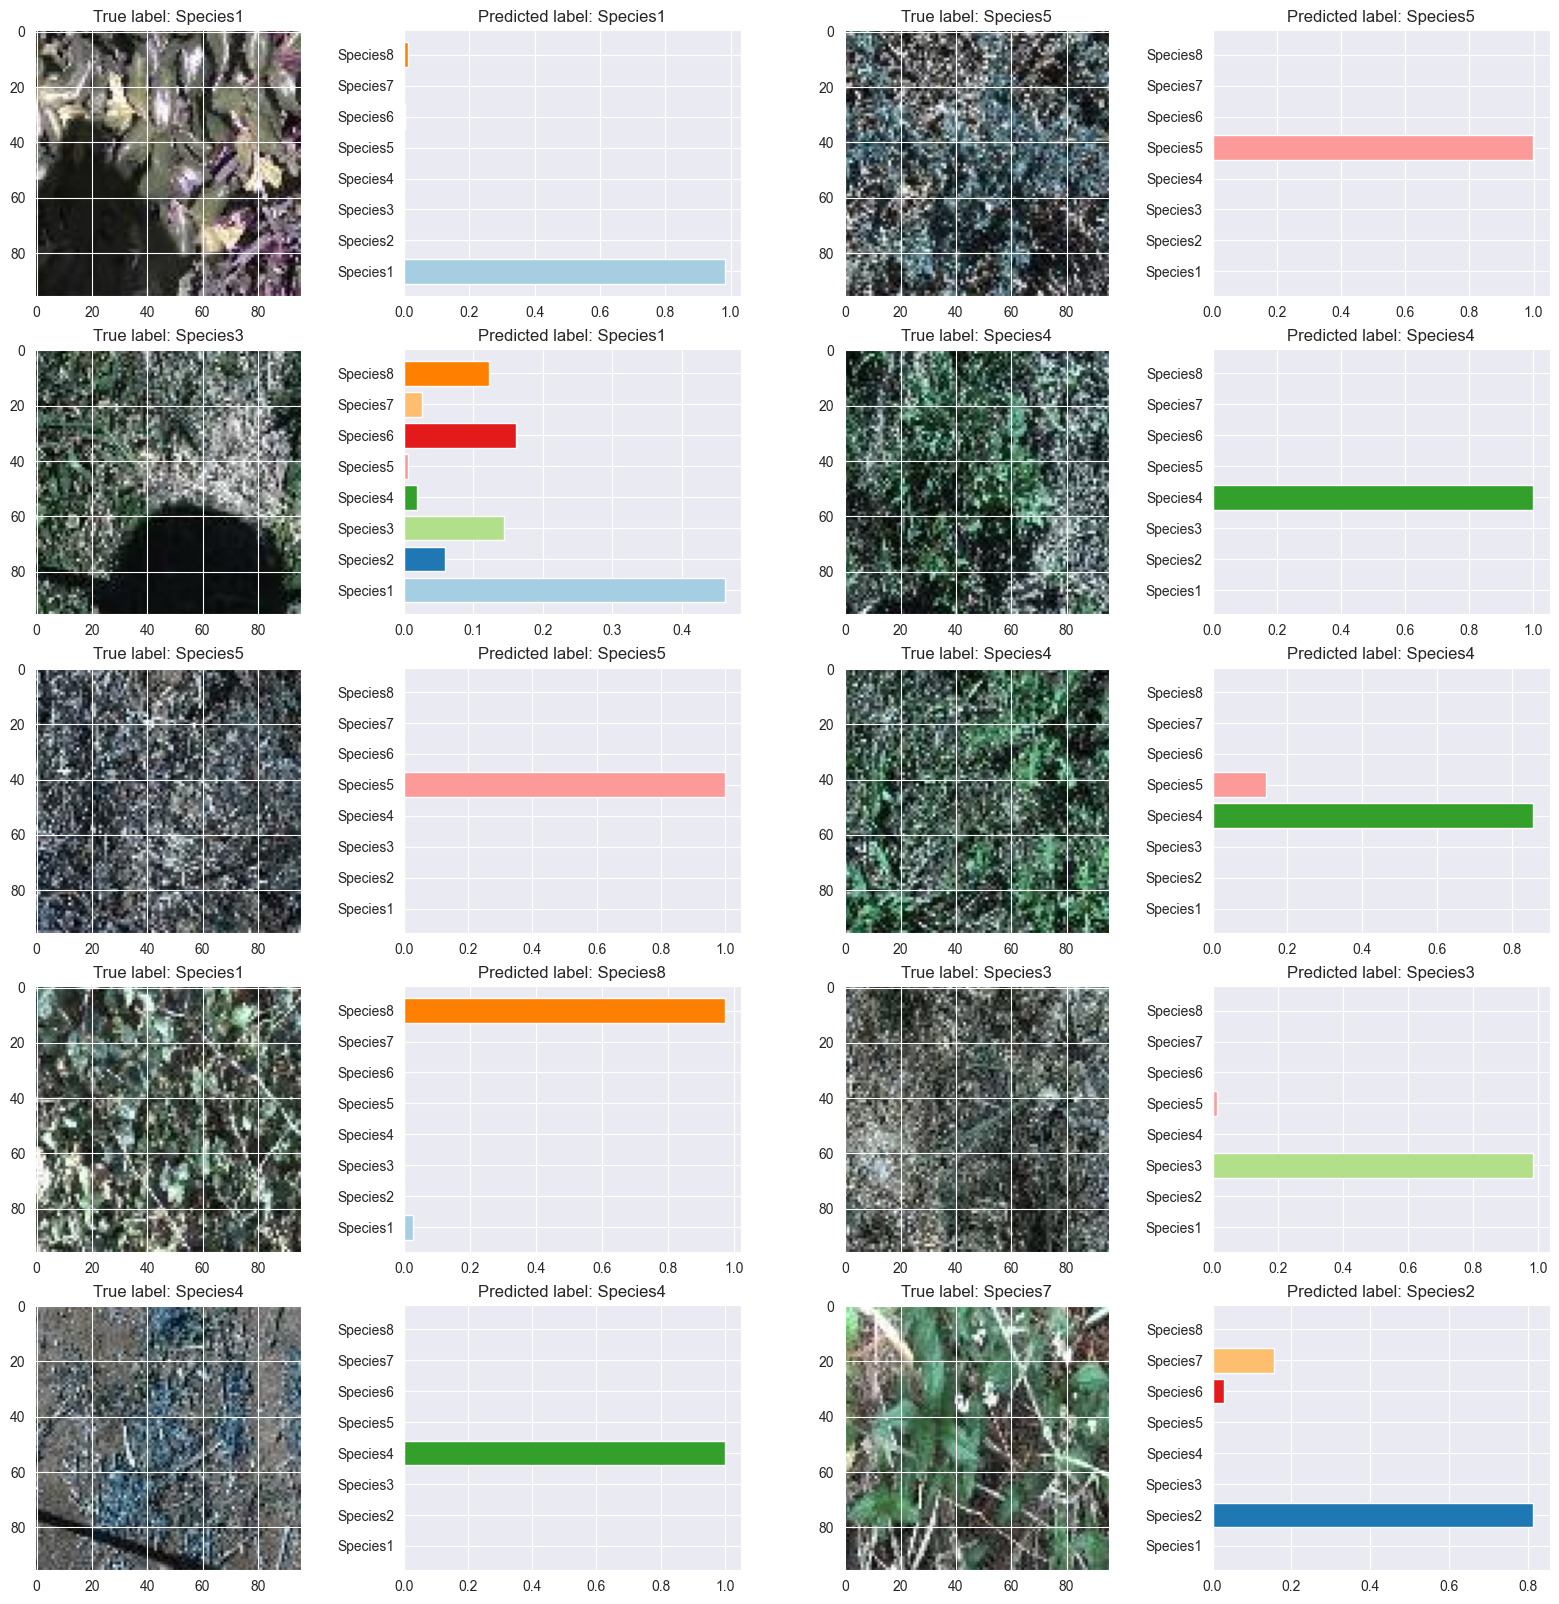

In [31]:
model_helper.show_predictions(X_test,Y_test,16)

BABABA


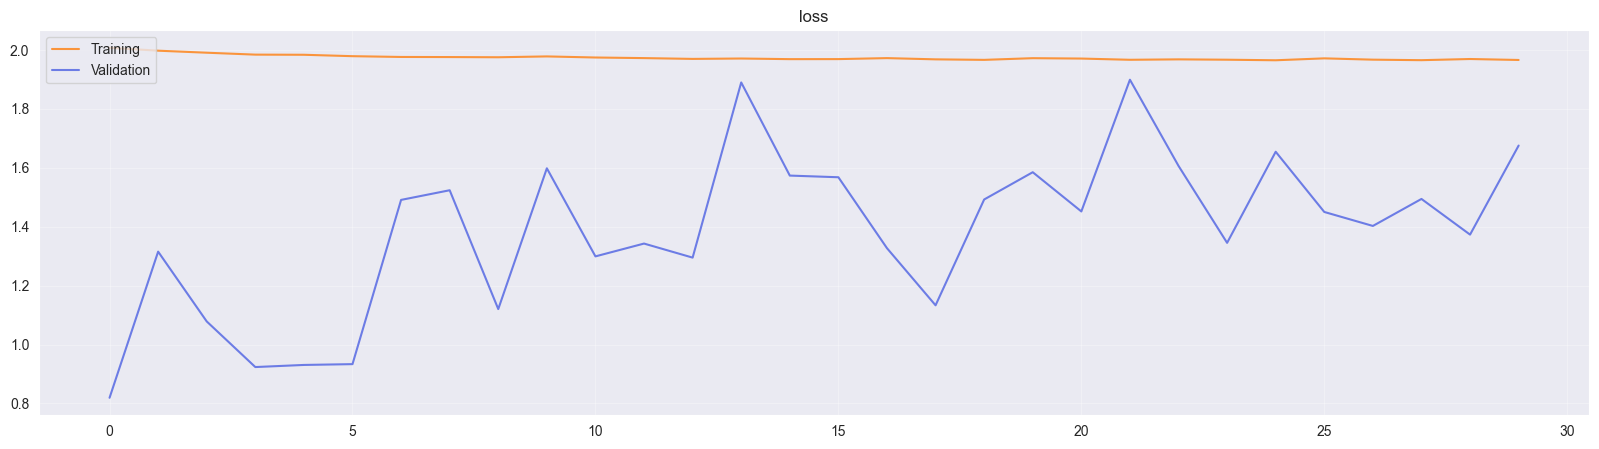

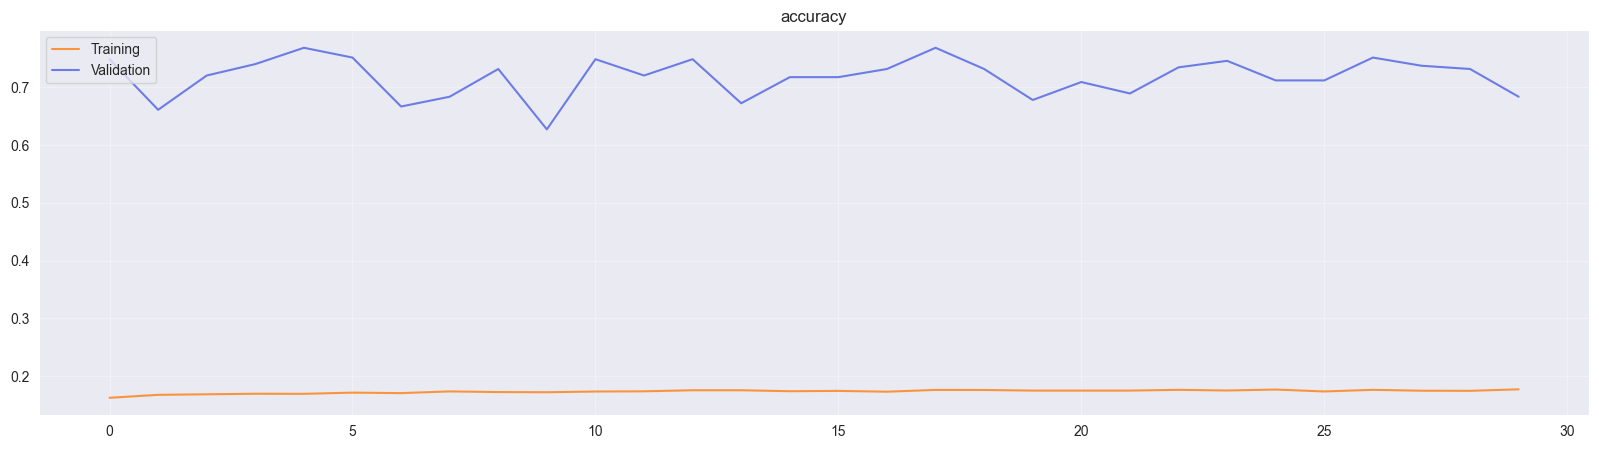

In [32]:
#PLOT THE TRAINING PHASE VS VALIDATION BOTH IN LOSS AND ACCURACY
model_helper.plot_phase_train_vs_validation(history)

12/12 [==============================] - 0s 14ms/step
Accuracy: 0.7938
Precision: 0.7752
Recall: 0.7722
F1: 0.7698


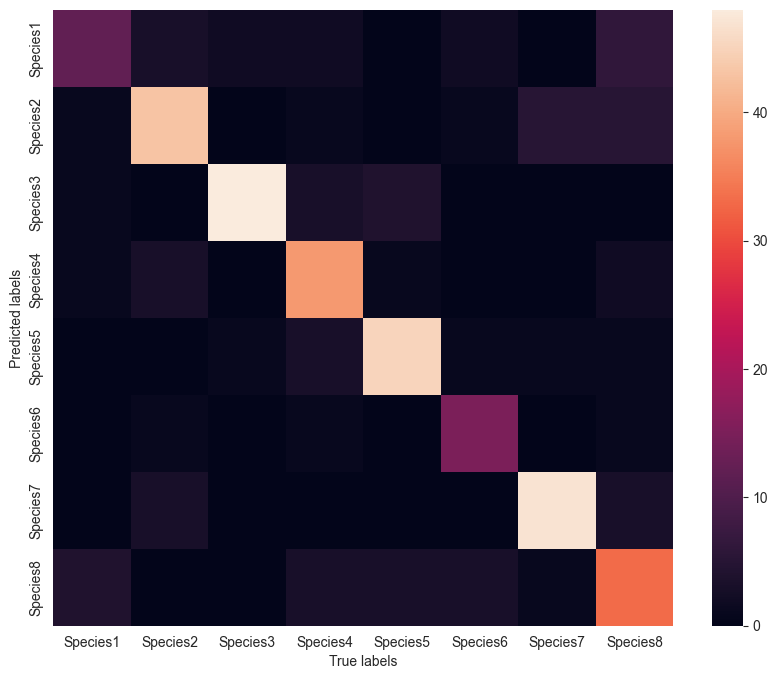

In [33]:
#PLOT CONFUSION MATRIX OF OUR MODEL
#It is good if diagonal has high values and other part of matrix is dark
#Bad if a row has ALL dark cells
#EG species 1 and species 6 has less images in the datase... and here the confusion matrix has all black on them..
model_helper.show_confusion_matrix(X_test,Y_test)

In [70]:
#Submission Model for the challenge -> Path is the folder on the server where our script is
class SubmissionModel:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model1'))

    def predict(self, X):

        # Insert your preprocessing here

        out = self.model.predict(X)
        out = np.argmax(out, axis=-1)
        return out

In [ ]:
testing_index = 44
image_to_test = X_test[[testing_index],:]
#image_to_test = X_test[10,None,:]
#image_to_test = np.expand_dims(image_to_test,0)
image_to_test.shape


In [ ]:
print("Real Class: ")
print(labels[np.argmax(Y_test[testing_index])])
tester = SubmissionModel("../../local_saved_models/")
res = tester.predict(image_to_test)
labels[res[0]]

In [ ]:
#Predict all test at oance
predicted_vector = model.predict(X_test)
predicted_vector.shape